<a href="https://colab.research.google.com/github/Tepuy-A/Tesis-2/blob/main/Ising_LinReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Panorama general
Consideremos el modelo Ising 1D con interacciones vecino más cercano

$$H[\boldsymbol{S}]=-J\sum_{j=1}^L S_{j}S_{j+1}$$

en una cadena de longitud $L$ con condiciones de contorno periódicas y $S_j=\pm 1$ variables de espín de Ising. En una dimensión, este modelo paradigmático no tiene transición de fase a temperatura finita.



### Aprendizaje del modelo Ising ###


Supongamos que tu jefe fija $J=1$, dibuja un gran número de configuraciones de espín y calcula sus energías de Ising. Entonces, sin decirle nada sobre el Hamiltoniano anterior, él o ella le entregó un conjunto de datos de $i=1\ldots n$ puntos de la forma $\{(H[\boldsymbol{S}^i],\boldsymbol{S}^i)\}$. La tarea es aprender el Hamiltoniano utilizando técnicas de regresión lineal.

In [ ]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
warnings.filterwarnings('ignore')

# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    L = states.shape[1]
    J = np.zeros((L, L),)
    for i in range(L):
        J[i,(i+1)%L]=-1.0 # interaction between nearest-neighbors

    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states)

## Reformular el problema como una regresión lineal
En primer lugar, tenemos que decidir qué clase de modelo (posibles hamiltonianos) utilizamos para ajustar los datos. En ausencia de cualquier conocimiento previo, una elección sensata es el modelo de Ising completo

$$
H_\mathrm{model}[\boldsymbol{S}^i] = - \sum_{j=1}^L \sum_{k=1}^L J_{j,k}S_{j}^iS_{k}^i.
$$
Nótese que este modelo está definido de forma única por las fuerzas de acoplamiento no locales $J_{jk}$ que queremos aprender. Es importante destacar que este modelo es lineal en ${\mathbf J}$$, lo que permite utilizar la regresión lineal.

Para aplicar la regresión lineal, nos gustaría refundir este modelo en la forma
$$
H_\mathrm{model}^i \equiv \mathbf{X}^i \cdot \mathbf{J},
$$


donde los vectores $\mathbf{X}^i$ representan todas las interacciones de dos cuerpos $\{S_{j}^iS_{k}^i \}_{j,k=1}^L$, y el índice $i$ recorre las muestras del conjunto de datos. Para completar la analogía, también podemos representar el producto punto mediante un único índice $p = \{j,k\}$, es decir, $\mathbf{X}^i \cdot \mathbf{J}=X^i_pJ_p$. Obsérvese que el modelo de regresión no incluye el signo menos, por lo que esperamos aprender $J$ negativos.

In [ ]:
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))

# build final data set
Data=[states,energies]

## Experimentos numéricos

Aprender no es ajustar: la sutil diferencia es que una vez que ajustamos los datos para obtener un modelo candidato, esperamos que se generalice a datos no vistos que no se hayan utilizado para el procedimiento de ajuste. Por esta razón, empezamos especificando un conjunto de datos de entrenamiento y otro de prueba

In [ ]:
# define number of samples
n_samples=400
# define train and test data sets
X_train=Data[0][:n_samples]
Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples//2]
Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

# Evaluación del rendimiento: coeficiente de determinación $R^2$



A continuación se evalúa el rendimiento del modelo (dentro y fuera de la muestra) mediante el denominado coeficiente de determinación, que viene dado por:
\begin{align}
R^2 &= \left(1-\frac{u}{v}\right),\\
u&=(y_{pred}-y_{true})^2\\
v&=(y_{true}-\langle y_{true}\rangle)^2
\end{align}

La mejor puntuación posible es 1,0, pero también puede ser negativa. Un modelo constante que siempre predice el valor esperado de $y$, $\langle y_{true}\rangle$, sin tener en cuenta las características de entrada, obtendría una puntuación $R^2$ de 0.

In [ ]:
#Custom Colormap

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list.

        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.

        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))

    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

hex_list = ['#009ca6','#ffffff','#dc582a']

## Aplicando OLS, regresión Ridge y LASSO:

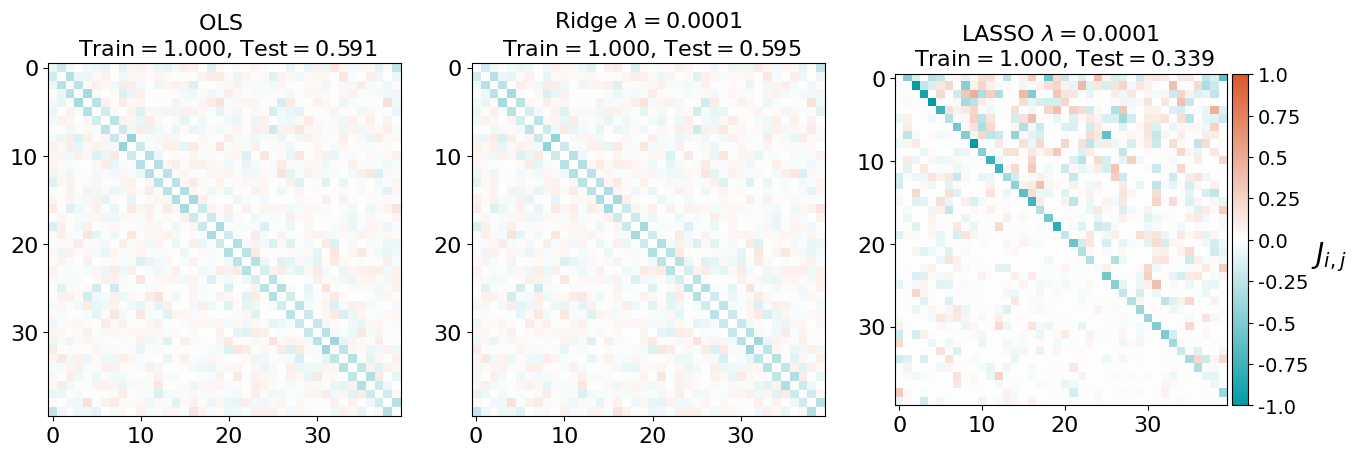

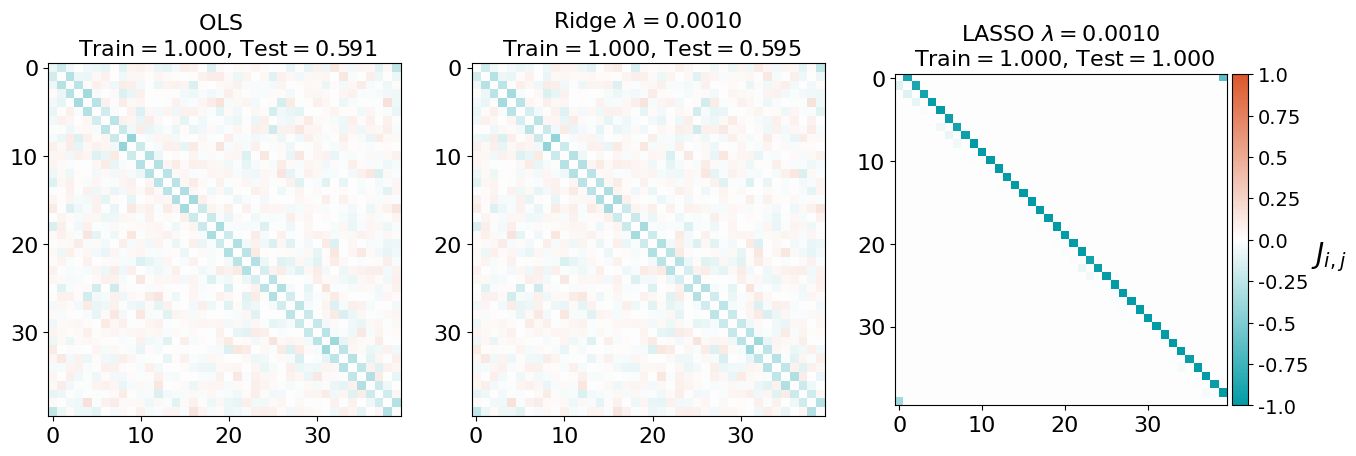

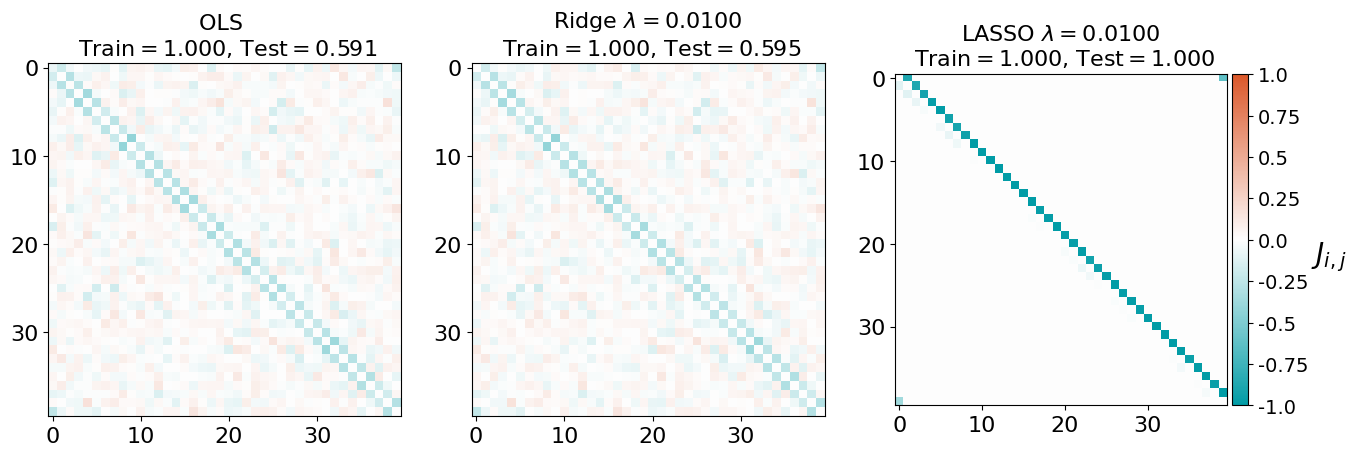

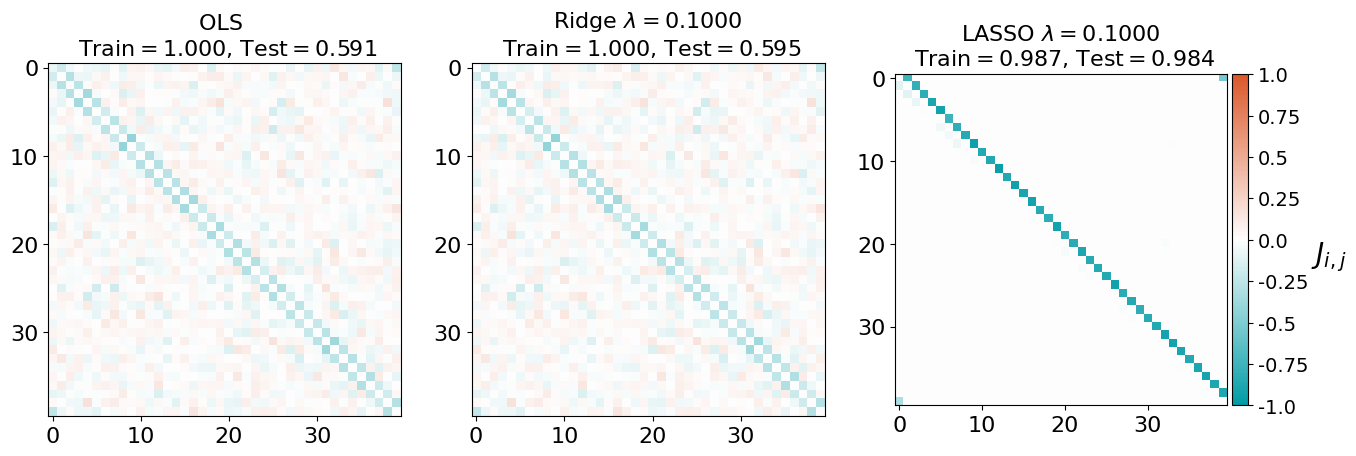

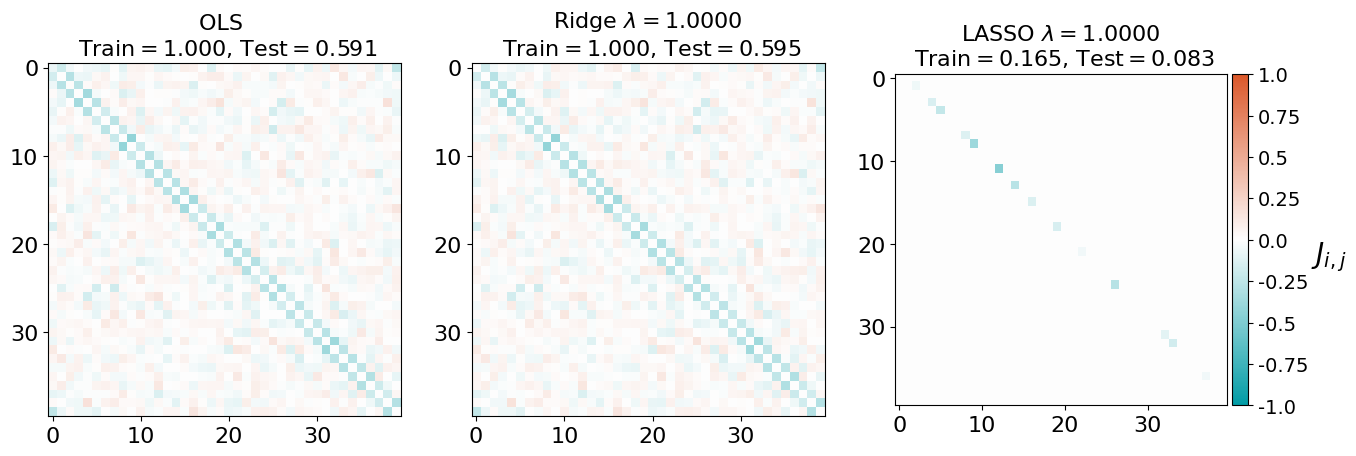

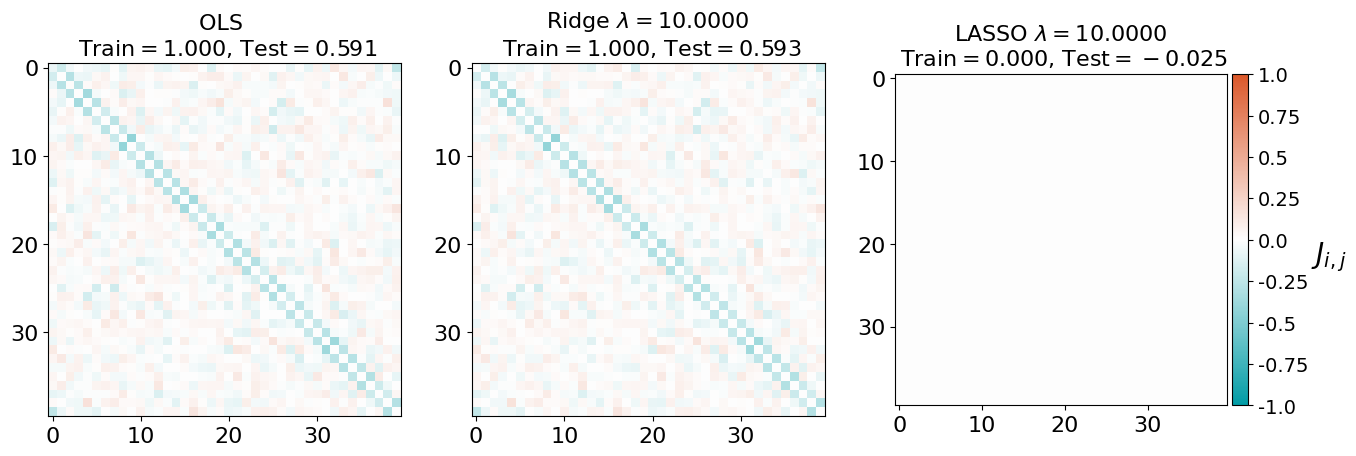

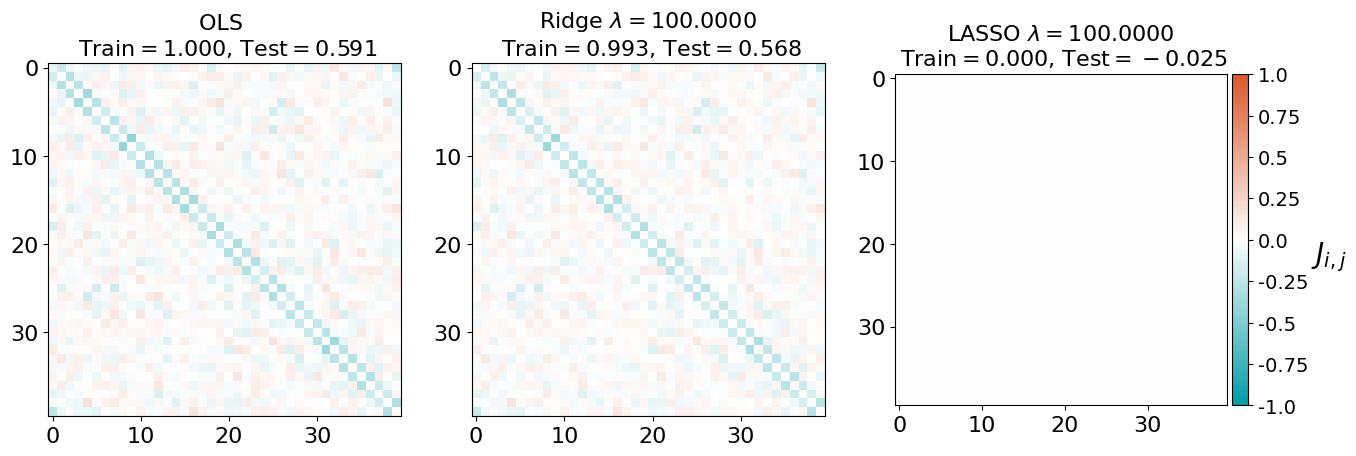

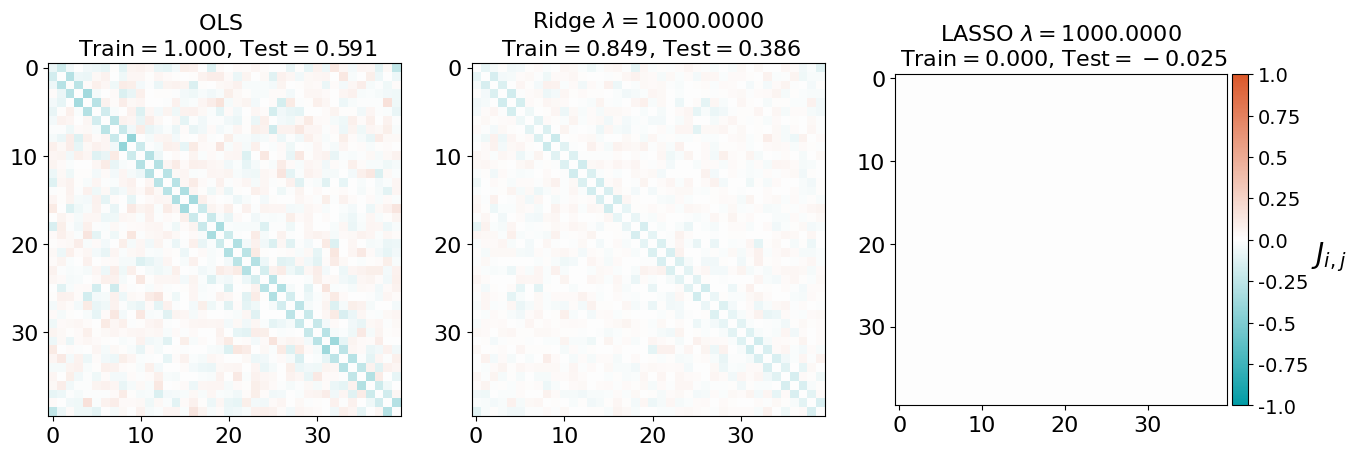

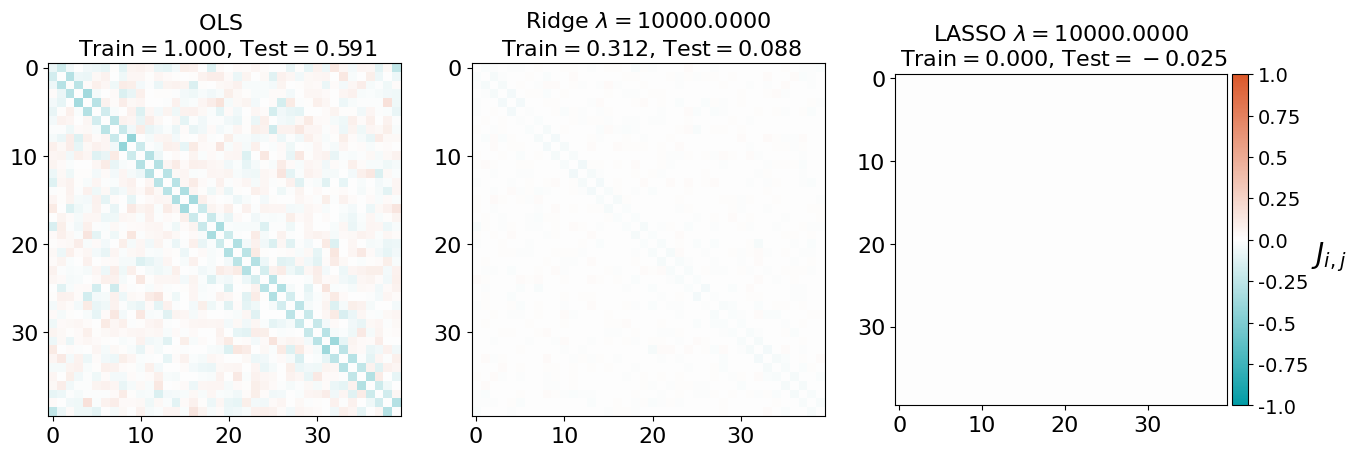

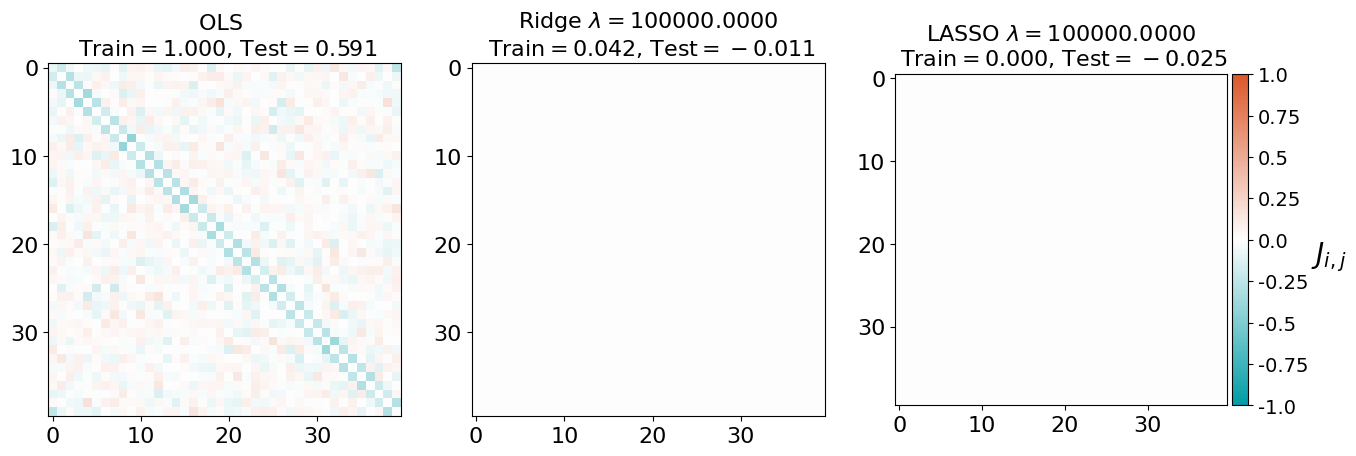

In [ ]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
leastsq=linear_model.LinearRegression()
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []

train_errors_ridge = []
test_errors_ridge = []

train_errors_lasso = []
test_errors_lasso = []

# set regularisation strength values
lmbdas = np.logspace(-4, 5, 10)

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

for lmbda in lmbdas:

    ### ordinary least squares
    leastsq.fit(X_train, Y_train) # fit model
    coefs_leastsq.append(leastsq.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_leastsq.append(leastsq.score(X_train, Y_train))
    test_errors_leastsq.append(leastsq.score(X_test,Y_test))

    ### apply RIDGE regression
    ridge.set_params(alpha=lmbda) # set regularisation parameter
    ridge.fit(X_train, Y_train) # fit model
    coefs_ridge.append(ridge.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, Y_train))
    test_errors_ridge.append(ridge.score(X_test,Y_test))

    ### apply LASSO regression
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))

    ### plot Ising interaction J
    J_leastsq=np.array(leastsq.coef_).reshape((L,L))
    J_ridge=np.array(ridge.coef_).reshape((L,L))
    J_lasso=np.array(lasso.coef_).reshape((L,L))

    customcmap = get_continuous_cmap(hex_list)

    cmap_args=dict(vmin=-1., vmax=1., cmap=customcmap)

    fig, axarr = plt.subplots(nrows=1, ncols=3)

    axarr[0].imshow(J_leastsq,**cmap_args)
    axarr[0].set_title('OLS \n Train$=%.3f$, Test$=%.3f$'%(train_errors_leastsq[-1], test_errors_leastsq[-1]),fontsize=16)
    axarr[0].tick_params(labelsize=16)

    axarr[1].imshow(J_ridge,**cmap_args)
    axarr[1].set_title('Ridge $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lmbda,train_errors_ridge[-1],test_errors_ridge[-1]),fontsize=16)
    axarr[1].tick_params(labelsize=16)

    im=axarr[2].imshow(J_lasso,**cmap_args)
    axarr[2].set_title('LASSO $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lmbda,train_errors_lasso[-1],test_errors_lasso[-1]),fontsize=16)
    axarr[2].tick_params(labelsize=16)

    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    #cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    cbar=fig.colorbar(im, cax=cax)

    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=15, y=0.5,fontsize=20,rotation=0)

    fig.subplots_adjust(right=2.0)

    plt.show()

In [ ]:
lmbdas

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05])

In [ ]:
np.shape(coefs_leastsq)

(10, 1600)

Para cuantificar el aprendizaje, también trazamos los errores dentro y fuera de la muestra

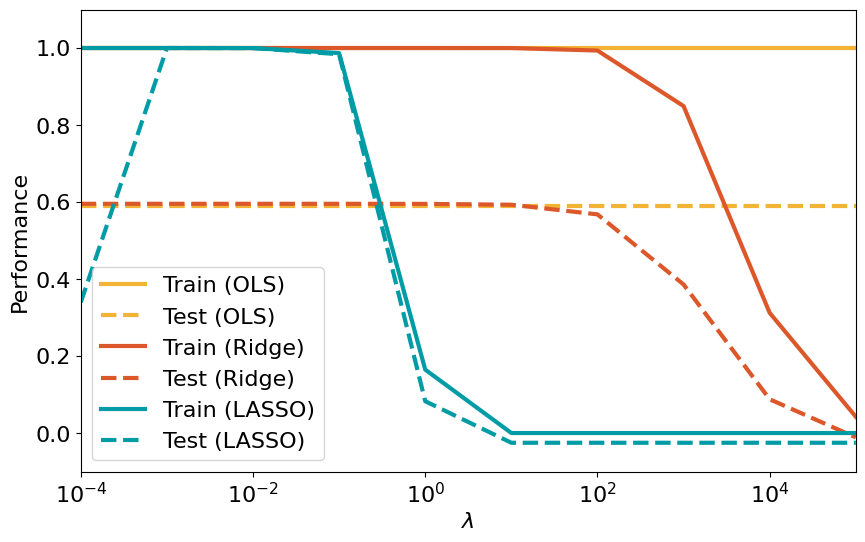

In [ ]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_errors_leastsq, color = '#f1b434',linewidth=3,label='Train (OLS)')
plt.semilogx(lmbdas, test_errors_leastsq,'--', color = '#f1b434',linewidth=3,label='Test (OLS)')
plt.semilogx(lmbdas, train_errors_ridge,color='#dc582a',linewidth=3,label='Train (Ridge)')
plt.semilogx(lmbdas, test_errors_ridge,'--',color='#dc582a',linewidth=3,label='Test (Ridge)')
plt.semilogx(lmbdas, train_errors_lasso,color='#009ca6',linewidth=3,label='Train (LASSO)')
plt.semilogx(lmbdas, test_errors_lasso, '--',color='#009ca6',linewidth=3,label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left',fontsize=16)
plt.ylim([-0.1, 1.1])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('Performance',fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

## Comprender los resultados

Hagamos algunas observaciones:

(i) el parámetro de regularización inverso (véase [documentación de Scikit](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)) $\lambda$ afecta a las regresiones Ridge y LASSO a escalas, separadas por unos pocos órdenes de magnitud.

(ii) en $\lambda\to 0$ y $\lambda\to\infty$, los tres modelos sobreajustan los datos, como puede verse por la desviación de los errores de prueba de la unidad (líneas discontinuas), mientras que las curvas de entrenamiento permanecen en la unidad.

(iii) Mientras que las curvas de prueba de OLS y de regresión Ridge son monotónicas, la curva de prueba LASSO no lo es, lo que sugiere que el parámetro óptimo de regularización LASSO es de aproximadamente 10^{-2}$. En este punto óptimo, las ponderaciones de interacción de Ising ${\bf J}$ contienen sólo términos de vecino más cercano (al igual que el modelo a partir del cual se generaron los datos).

Recordemos que la fuerza de las interacciones uniformes entre vecinos más cercanos $J_{j,k}=J$ que utilizamos para generar los datos se fijó en la unidad, $J=1$. Además, $J_{j,k}$ NO se definió para que fuera simétrica (sólo utilizamos los elementos $J_{j,j+1}$ pero nunca los $J_{j,j-1}$). La barra de color en el gráfico de elementos de matriz anterior sugiere que la regresión OLS y Ridge aprenden pesos simétricos uniformes $J=-0,5$. No hay ningún misterio, ya que esto equivale a tener en cuenta tanto los términos $J_{j,j+1}$ como los $J_{j,j-1}$, y los pesos se distribuyen simétricamente entre ellos. LASSO, en cambio, puede romper esta simetría (véanse los gráficos de elementos de matriz para $\lambda=0,001$ y $\lambda=0,01$). Así, vemos cómo diferentes esquemas de regularización pueden conducir al aprendizaje de modelos equivalentes pero en diferentes calibres. Cualquier información que tengamos sobre la simetría del modelo desconocido que generó los datos debe reflejarse en la definición del modelo y en la regularización elegida.